# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Feature_Selection"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

모델이 테스트 세트보다 훈련 세트에서 성능이 높다면 <b>과대적합</b><sup>overfitting</sup>에 대한 강력한 신호다. 괘다적합은 모델 파라미터가 훈련 세트에 있는 특정 샘플들에 대해 너무 가깝게 맞춰져 있다는 의미다. 새로운 데이터에는 잘 일반화하지 못하기 때문에 모델 분산이 크다고 말한다. 과대적합의 이유는 주어진 훈련 데이터에 비해 모델이 너무 복잡하기 때문이다. 일반화 오차를 감소시키기 위해 많이 사용하는 방법은 다음과 같다.

<ul>
    <li>더 많은 훈련 데이터를 모은다.</li>
    <li>규제를 통해 복잡도를 제한한다.</li>
    <li>파라미터 개수가 적은 간단한 모델을 선택한다.</li>
    <li>데이터 차원을 줄인다.</li>
</ul>

특성 선택을 통해 차원을 축소하면 데이터에 학습되는 파라미터 개수가 줄어들기 때문에 더 간단한 모델을 만든다.

# 순차 특성 선택 알고리즘

모델 복잡도를 줄이고 과대적합을 피하는 다른 방법은 특성 선택을 통한 <b>차원 축소</b><sup>dimensionality reduction</sup>이다. 규제가 없는 모델에서 특히 유용하다. 차원 축소 기법에는 두 개의 주요 카테고리인 <b>특성 선택</b><sup>feature selection</sup>과 <b>특성 추출</b><sup>feature extraction</sup>이 있다. 특성 선택은 원본 특성에서 일부를 선택한다. 특성 추출은 일련의 특성에서 얻은 정보로 새로운 특성을 만든다.

<b>순차 특성 선택</b><sup>sequential feature selection</sup> 알고리즘은 탐욕적 탐색 알고리즘<sup>greedy search algorithm</sup>으로 초기 $d$차원의 특성 공간을 $k < d$인 $k$ 차원의 특성 부분 공간으로 축소한다. 특성 선택 알고리즘은 주어진 문제에 가장 관련이 높은 특성 부분집합을 자동으로 선택하는 것이 목적이다. 관계없는 특성이나 잡음을 제거하여 계산 효율성을 높이고 모델의 일반화 오차를 줄인다. 규제를 제공하지 않는 알고리즘을 사용할 때 유용하다.

전통적인 순차 특성 선택 알고리즘은 <b>순차 후진 선택</b><sup>Sequential Backward Selection, SBS</sup>이다. 계산 효율성을 향상하기 위해 모델 성능을 가능한 적게 희생하면서 초기 특성의 부분 공간으로 차원을 축소한다. 과대적합의 문제를 안고 있는 모델이라면 SBS가 예측 성능을 높일 수도 있다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> <b>탐욕적 알고리즘</b><sup>greedy algorithm</sup>은 조합 탐색<sup>combinatorial search</sup> 문제의 각 단계에서 국부적으로 최적의 선택을 한다. 일반적으로 해당 문제에 대한 차선의 솔루션을 만든다. <b>완전 탐색 알고리즘</b><sup>exhaustive search algorithm</sup>은 모든 가능한 조합을 평가하므로 최적의 솔루션을 찾을 것이라고 보장된다. 실전에서는 완전 탐색이 계산하기 불가능한 경우가 많고 탐욕적 알고리즘이 덜 복잡하고 효율적으로 계산할 수 있는 솔루션을 만들 수 있다.
    </div>

SBS 알고리즘 이면의 아이디어는 매우 간단하다. SBS는 새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거한다. 각 단계에서 어떤 특성을 제거할지 판단하기 위해 최소화할 기준 함수를 정의한다. 기준 함수에서 계산한 값은 어떤 특성을 제거하기 전후의 모델 성능 차이다. 각 단계에서 제거할 특성은 기준 값이 가장 큰 특성으로 정의할 수 있다. 이해하기 쉽게 말하면 각 단계에서 제거했을 때 성능 손실이 최대가 되는 특성을 제거한다. SBS 정의에 따라 이 알고리즘을 간단히 네 단계로 정리할 수 있다.

<ol>
    <li>알고리즘을 $k=d$로 초기화한다. $d$는 전체 특성 공간 $\mathrm{X}_d$의 차원이다.</li>
    <li>조건 $\mathrm{x}^- = \text{arg max}J(\mathrm{X}_k - \mathrm{x})$를 최대화하는 특성 $x^-$를 결정한다. 여기서 $x\in\mathrm{X}_k$이다.</li>
    <li>특성 집합에서 특성 $x^-$를 제거한다. 즉, $\mathrm{X}_{k-1}:=\mathrm{X}_k-\mathrm{x}^-;k:=k-1$이다.</li>
    <li>$k$가 목표하는 특성 개수가 되면 종료한다. 아니면 단계 2로 돌아간다.</li>
</ol>

안타깝지만 SBS 알고리즘은 아직 사이킷런에 구현되어 있지 않다. 간단한 알고리즘이므로 파이썬으로 직접 구현해 보자.

In [11]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features,
                 scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test,self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test,
                    indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

이 구현에서 목표 특성 개수를 지정하기 위해 k_features 매개변수를 정의했다. 기본적으로 사이킷런의 <code>accuracy_score()</code> 함수를 사용하여 특성의 부분 집합에 대한 모델(분류를 위한 추정기) 성능을 평가한다. <code>fit()</code> 메서드의 while 루프 안에서 <code>itertools.combination()</code> 함수에 의해 생성된 특성 조합을 평가하고 원하는 차원이 남을 때까지 특성을 줄인다. 각 반복에서 내부적으로 만든 X_test 테스트 세트에 기초한 최적 조합의 정확도 점수를 self.scores_ 리스트에 모은다. 이 점수를 사용하여 나중에 결과를 평가하겠다. 최종 선택된 특성의 열 인덱스는 self.indices_에 할당된다. <code>transform()</code> 메서드에서 선택된 특성 열로 구성된 새로운 데이터 배열을 반환할 때 사용한다. <code>fit()</code> 메서드 안에서 명시적으로 특성에 대한 기준 값을 계산하는 대신 최적의 특성 조합에 포함되지 않은 특성을 제외했다.

사이킷런의 KNN 분류기를 사용하여 이 SBS 구현이 잘 동작하는지 확인해보자.

In [19]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# 특성을 선택한다.
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

SBS 구현이 <code>fit()</code> 메서드 안에서 데이터셋을 훈련 세트와 테스트 세트로 나누지만 여전히 이 알고리즘에 X_train 데이터만 주입한다. SBS의 <code>fit()</code> 메서드는 훈련과 테스트(검증)를 위한 새로운 부분 세트를 만든다. 여기서 테스트 세트를 <b>검증 세트</b><sup>validation set</sup>라고도 부른다. 이 방식을 사용하려면 훈련 데이터에서 테스트 세트를 미리 떼어 놓아야 한다.

SBS 알고리즘은 각 단계에서 가장 좋은 특성 조합의 점수를 모았다. 검증 세트에서 계산한 KNN 분류기의 정확도를 그려 보겠다. 코드는 다음과 같다.

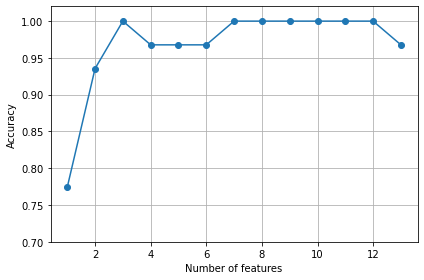

In [21]:
# 특성 조합의 성능 그래프를 출력한다.
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

위 그림에서 볼 수 있듯이 특성 개수가 줄었을 때 검증 세트에서 KNN 분류기의 정확도가 향상되었다. KNN 알고리즘에서 설명했던 <b>차원의 저주</b>가 감소하기 때문이다. 또 $k$={3, 7, 8, 9, 10, 11, 12}에서 분류기가 100% 정확도를 달성한 것을 볼 수 있다.

가장 작은 개수의 조합($k$=3)에서 높은 검증 세트 성능을 내는 특성이 어떤 것인지 확인해보자.

In [31]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


이 코드는 sbs.subsets_ 속성의 11번째 위치에 있는 세 개의 특성에 대한 열 인덱스를 얻는다.<sup><a id="a01" href="#p01">[1]</a></sup> 이 열 인덱스로부터 판다스 Wine DataFrame의 특성 이름을 출력한다.

이제 원래 테스트 세트에서 KNN 분류기의 성능을 평가해보자.

In [32]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


전체 특성 조합을 사용하여 훈련 세트에서 약 97% 정확도와 테스트 세트에서 약 96% 정확도를 얻었다. 새로운 데이터에도 잘 일반화될 것으로 보인다. 이제 선택된 세 개의 특성에서 KNN 성능이 얼마나 되는지 확인해보자.

In [34]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


Wine 데이터셋에 있는 원본 특성의 4분의 1보다도 적은 특성을 사용했지만 테스트 세트의 예측 정확도는 조금만 감소했다. 이 세 개의 특성에 담긴 판별 정보가 원래 데이터셋보다 적지 않다는 뜻이다. Wine 데이터셋은 작은 데이터셋이라는 점을 유념하자. 무작위성에 매우 민감하다. 즉, 데이터셋을 훈련 세트와 테스트 세트로 나눈 것과 다시 훈련 세트와 검증 세트로 나눈 방식에 영향을 받는다.

특성 개수를 줄여서 KNN 모델의 성능이 증가하지는 않았지만 데이터셋 크기를 줄였다. 데이터 수집 비용이 높은 실전 애플리케이션에서는 유용할 수 있다. 또 특성 개수를 크게 줄였기 때문에 더 간단한 모델을 얻었고 해석하기도 쉽다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> <b>사이킷런의 특성 선택 알고리즘</b><br><br>사이킷런에는 특성 선택 알고리즘이 많이 준비되어 있다. 특성 가중치에 기반을 둔 <b>재귀적 특성 제거</b><sup>recursive feature elimination</sup>, 특성 중요도를 사용한 트리 기반 방법, 일변량 통계 테스트<sup>univariate statistical test</sup>가 있다. 사이킷런의 온라인 문서(<a href='https://scikit-learn.org/stable/modules/feature_selection.html' target='blank'>https://scikit-learn.org/stable/modules/feature_selection.html</a>)에서 좋은 예제와 설명을 참고하자.
    </div>

# 랜덤 포레스트의 특성 중요도 사용

데이터셋에서 유용한 특성을 선택하는 또 다른 방법은 Decision Tree에서 소개한 앙상블 기법인 <b>랜덤 포레스트</b>를 사용하는 것이다. 랜덤 포레스트를 사용하면 앙상블에 참여한 모든 결정 트리에서 계산한 평균적인 불순도 감소로 특성 중요도를 측정할 수 있다. 데이터셋이 선형적으로 구분 가능한지 여부를 가정할 필요가 없다. 편리하게도 사이킷런의 랜덤 포레스트 구현은 특성 중요도 값을 이미 수집하고 있다. RandomForestClassifier 모델을 훈련한 후 feature_importances_ 속성에서 확인할 수 있다.<sup><a id="a02" href="#p02">[2]</a></sup> 다음 코드에서 Wine 데이터셋에서 500개의 트리를 가진 랜덤 포레스트를 훈련하고 각각의 중요도에 따라 13개의 특성에 순위를 매긴다. 트리 기반 모델은 표준화나 정규화를 할 필요가 없다고 했었다.

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


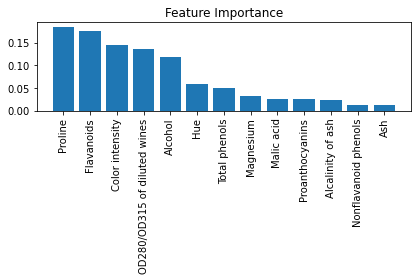

In [41]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
         align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

코드를 실행하면 Wine 데이터셋 특성의 상대적인 중요도에 따른 순위를 그래프로 그린다. 특성 중요도는 합이 1이 되도록 정규화된 값이다.

500개의 결정 트리에서 평균적인 불순도 감소를 기반으로 이 데이터셋에서 가장 판별력이 좋은 특성은 Proline, Flavanoids, Color intensity, OD280/OD315 of diluted wines, Alcohol이다. 재미있게도 이 그래프에서 높은 순위에 위치한 특성 중 두 개는 이전 절에서 구현한 SBS 알고리즘으로 선택한 세 개의 특성에 들어 있다(Alcohol과 OD280/OD315 of diluted wines). 모델 해석을 중요하게 고려한다면 랜덤 포레스트 기법에서 언급할 만한 중요한 참고 사항이 있다. 랜덤 포레스트에서 두 개 이상의 특성이 매우 상관관계가 높다면 하나의 특성은 매우 높은 순위를 갖지만 다른 특성 정보는 완전히 잡아내지 못할 수 있다. 특성 중요도 값을 해석하는 것보다 모델의 예측 성능에만 관심이 있다면 이 문제를 신경 쓸 필요는 없다.

특성 중요도에 관한 이 절을 마무리하기 위해 사이킷런의 SelectFromModel을 살펴보겠다. 이 클래스는 모델 훈련이 끝난 후 사용자가 지정한 임계 값을 기반으로 특성을 선택한다. Pipeline의 중간 단계에서 RandomForestClassifier를 특성 선택기로 사용할 때 유용하다. 예를 들어 다음 코드에서는 임계 값을 0.1로 하여 가장 중요한 다섯 개의 특성으로 데이터셋을 줄였다.

In [42]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:', X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


In [43]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


# 그림을 위한 코드

In [13]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('클래스 레이블', np.unique(df_wine['Class label']))
df_wine.head()

클래스 레이블 [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [14]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

In [15]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# 미주

<b id="p01">1</b> 전체 특성으로 시작해서 하나씩 제거하기 때문에 subsets_ 속성의 11번째 원소가 특성이 세 개 남았을 때다. [↩](#a01)

<b id="p02">2</b> 결정 트리의 특성 중요도는 노드에 사용된 특성별로 (부모 노드의 샘플 비율 x 불순도) - (왼쪽 자식 노드의 샘플 비율 x 불순도) - (오른쪽 자식 노드의 샘플 비율 x 불순도)를 계산하여 더하고, 특성 중요도의 합이 1이 되도록 정규화한 것이다. 여기서 샘플 비율은 전체 샘플 개수에 대한 비율이다. 랜덤 포레스트의 특성 중요도는 각 결정 트리 특성 중요도의 합을 트리 개수로 나눈 것이다. [↩](#a02)